# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, x, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("iteration", iteration_count, info, J_opt, dynamics.reduce_state(x))

In [6]:
dt = 0.05
dynamics = CartpoleDynamics(dt)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = 100 * np.eye(dynamics.state_size)
Q[1, 1] = Q[4, 4] = 10.0

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[1.0]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
T = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (T, dynamics.action_size))
ilqr = iLQR(dynamics, cost, T)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 200184.793967 [-0.02004778  0.00404668  2.50879873  0.01577107]
iteration 1 accepted 200105.855305 [-0.02149879  0.00956131  2.43664645  0.02719924]
iteration 2 accepted 200011.059848 [-0.02113658  0.01004702  2.34695434  0.0400046 ]
iteration 3 accepted 199889.393706 [-0.02267488  0.01052161  2.24255202  0.04700092]
iteration 4 accepted 199735.745076 [-0.02524172  0.01410945  2.12569875  0.04131096]
iteration 5 accepted 199547.924963 [-0.02825006  0.02284605  1.999835    0.01530657]
iteration 6 accepted 199328.620723 [-0.03079945  0.03706756  1.87081593 -0.03617298]
iteration 7 accepted 199085.854745 [-0.03158885  0.05452075  1.74665117 -0.11089169]
iteration 8 accepted 198829.829701 [-0.02953653  0.07126398  1.63495701 -0.19778235]
iteration 9 accepted 198568.315583 [-0.02469855  0.08457429  1.53967536 -0.2832644 ]
iteration 10 accepted 198305.065442 [-0.01824086  0.09449424  1.46032602 -0.35903282]
iteration 11 accepted 198041.277785 [-0.01143508  0.10246093  1.

iteration 96 failed 176276.124566 [-0.2088382  -0.16687588 -0.55868603  2.01771895]
iteration 97 failed 176276.124566 [-0.2088382  -0.16687588 -0.55868603  2.01771895]
iteration 98 failed 176276.124566 [-0.2088382  -0.16687588 -0.55868603  2.01771895]
iteration 99 accepted 175918.709148 [-0.322204    0.4774232  -2.77005287  6.0332321 ]
iteration 100 accepted 169959.078309 [-0.73381931 -0.28505657  1.47110097  3.65575162]
iteration 101 accepted 168987.148884 [-0.97641272 -0.4039507  -1.05122743 -2.80827695]
iteration 102 accepted 167310.044116 [-0.83943425 -0.06932667  0.21140044  0.4250155 ]
iteration 103 accepted 167204.977436 [-0.96889482 -0.46380783 -0.41194426 -1.15087085]
iteration 104 accepted 165698.271928 [-0.45812686 -0.07671243 -0.07815296 -0.2492063 ]
iteration 105 accepted 165256.922937 [-0.03049612  0.33918641  0.23917971  0.5849459 ]
iteration 106 accepted 165208.630353 [-0.10128178  0.23181811  0.10476002  0.25524278]
iteration 107 failed 165208.630353 [-0.10128178  0.23

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(T + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

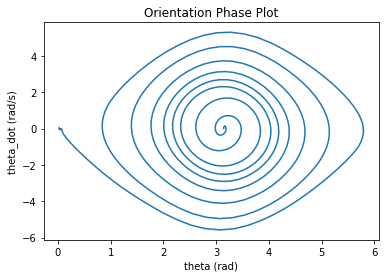

In [12]:
plt.plot(theta, theta_dot)
plt.xlabel("theta (rad)")
plt.ylabel("theta_dot (rad/s)")
plt.title("Orientation Phase Plot")

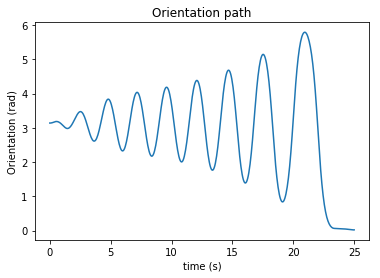

In [13]:
plt.plot(t, theta)
plt.xlabel("time (s)")
plt.ylabel("Orientation (rad)")
plt.title("Orientation path")

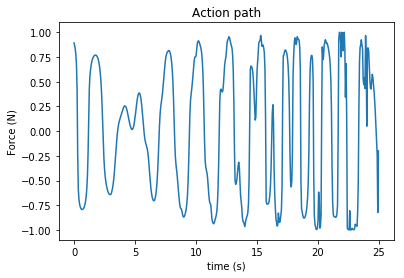

In [14]:
plt.plot(t[:-1], us)
plt.xlabel("time (s)")
plt.ylabel("Force (N)")
plt.title("Action path")

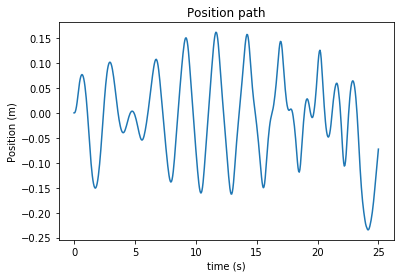

In [15]:
plt.plot(t, x)
plt.xlabel("time (s)")
plt.ylabel("Position (m)")
plt.title("Position path")

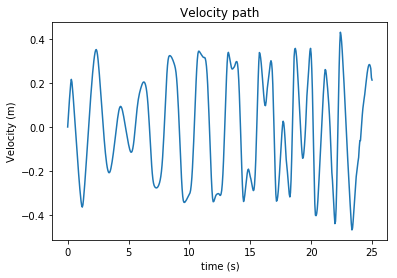

In [16]:
plt.plot(t, x_dot)
plt.xlabel("time (s)")
plt.ylabel("Velocity (m)")
plt.title("Velocity path")

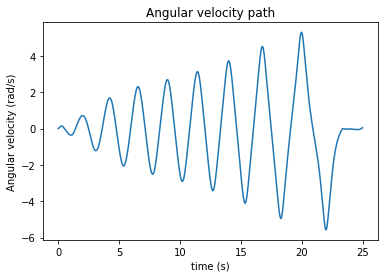

In [17]:
plt.plot(t, theta_dot)
plt.xlabel("time (s)")
plt.ylabel("Angular velocity (rad/s)")
plt.title("Angular velocity path")

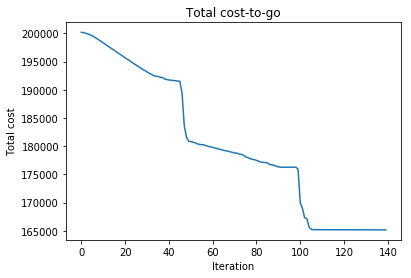

In [18]:
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("Total cost")
plt.title("Total cost-to-go")